In [2]:
from database import * 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

type_all = execute_sql('select name from type', 1)[0]
actor_all = execute_sql('select name from actor', 1)[0]
director_all = execute_sql('select name from director', 1)[0]
month = [i for i in range(1, 13)]

W = [1, 6, 3.5, 0.5]


In [3]:

def binary_rep(list):
    return [
        [1 if item in list[0] else 0 for item in type_all],
        [1 if item in list[1] else 0 for item in actor_all],
        [1 if item in list[2] else 0 for item in director_all],
        list[3]
    ]
    
def month_diff(m1, m2):
    if m1 < m2:
        m1, m2 = m2, m1
    return 1 - min(m1 - m2, m2 + 12 - m1) / 12 

In [4]:
def similarity(A, B):
    res = []
    for i in range(3):
        res.append(np.dot(A[i], B[i])/(np.linalg.norm(A[i]) * np.linalg.norm(B[i])))
    res.append(month_diff(A[3], B[3]))
    
    # 加权平均
    return np.dot(W, res)


In [5]:
# TEST
similarity_1 = similarity(
    binary_rep(
            [
                ['动画', '剧情'], 
                ['吴京', '易烊千玺', '沈腾', '尼古拉斯·卡斯柯恩'],
                ['徐克', '姜文'],
                10
            ]),   
    binary_rep(
            [
                ['爱情', '剧情', '奇幻'], 
                ['吴京', '沈腾', '彭于晏', '伯纳德·希尔'],
                ['姜文', '贾玲'],
                8
            ])
    )
similarity_1


5.574914957130529

In [12]:
if not os.path.isfile('../csv/binary_data.csv'):
    df = pd.read_csv('../csv/猫眼_豆瓣.csv')
    data = []
    for row in df.values:
        movie = []
        name, date, money, director, actor, type = (row[1], row[2], row[3], row[8], row[9], row[10])
        year, month, day = date.split('-')
        movie = binary_rep([type, actor, director, int(month)])
        # print(movie)
        movie.append(money)
        movie.append(int(year))
        movie.append(name)
        data.append(movie)

    data = pd.DataFrame(data, columns=['type', 'actor', 'director', 'month', 'money', 'year', 'name'])
    data.to_csv('../csv/binary_data.csv')

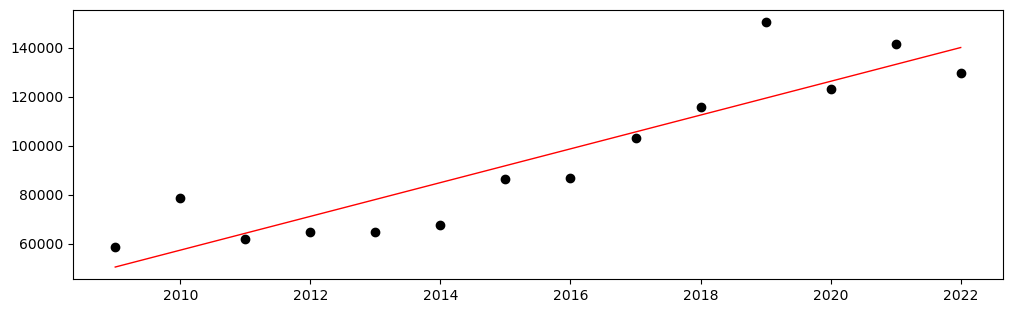

In [13]:
from sklearn.linear_model import LinearRegression 


sql =  'select  substr(date,1,4)  year, avg(money) count \
        from type t left outer join maoyan_movie_type mt on t.id = mt.type_id join maoyan_movie m on m.id = mt.maoyan_id\
        group by  year\
        order by  year\
        limit 1, 14'
x, y = execute_sql(sql, 2)
y = [float(i) for i in y]
x = np.array(x,dtype=int)
y = np.array(y,dtype=float)

reg = LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1))


plt.figure(figsize=(12, 3.5))
plt.scatter(x, y,  color='black')
plt.plot(x, reg.predict(x.reshape(-1, 1)), color='red', linewidth=1)
plt.show()




In [16]:
def predict(movie):
    movie = binary_rep(movie)
    data = pd.read_csv('../csv/binary_data.csv')
    
    
    res = []
    for item in data.values:
        type, actor, director = list(map(lambda x : eval(x), [item[1], item[2], item[3]]))
        month, money, year, name = item[4], int(item[5]), int(item[6]), item[7]
        res.append((similarity(movie, [type, actor, director, month]), money, year, name))
    
    res.sort(key=lambda x : -x[0])
    
    predict_val = 0
    cnt = 0
    for i in range(5):
        if res[i][0] <= 2:
            break
        cnt += 1
        predict_val += res[i][1] * reg.predict([[2023]]) / reg.predict([[res[i][2]]])
        
        print(res[i])
        
    return predict_val[0][0] / cnt


In [17]:
movie = [
    ['剧情', '历史'],
    ['吴京', '包贝尔', '易烊千玺', '邓超', '欧豪', '雷佳音', '郭京飞'],
    ['徐克', '吴京'],
    2
]

predict(movie)

(4.6808694950739635, 406733, 2022, '长津湖之水门桥')
(3.846339605633867, 577534, 2021, '长津湖')
(3.616970526244077, 165207, 2017, '西游伏妖篇')
(3.254676920420864, 54469, 2015, '战狼')
(3.2450937914128564, 88348, 2014, '智取威虎山')


306848.3916073195

In [18]:
movie = [
    ['爱情', '喜剧'],
    ['韩庚', '郑恺', '于文文', '刘雅瑟', '刘天爱'],
    ['田羽生'],
    10
]

predict(movie)

(8.941589026166287, 194190, 2017, '前任3：再见前任')
(3.0211400439542415, 58861, 2014, '匆匆那年')
(2.668806447200494, 71902, 2013, '致我们终将逝去的青春')


169230.68515821127